In [1]:
%matplotlib inline

In [2]:
import datajoint as dj
schema = dj.schema('dimitri_university')
schema.spawn_missing_classes()

Connecting dimitri@localhost:3306


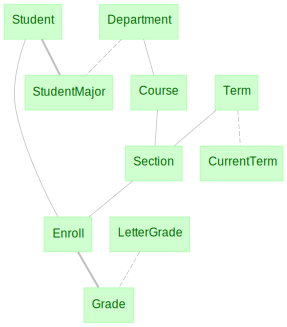

In [3]:
dj.ERD(schema)

# Generate fake data

In [4]:
# Cleanup from previous run
Department.delete()
Student.delete()
LetterGrade.delete()
Term.delete()

About to delete:
Nothing to delete
About to delete:
Nothing to delete
About to delete:
Nothing to delete
About to delete:
Nothing to delete


In [5]:
from tqdm import tqdm
import faker
import random
import itertools
import datetime
fake = faker.Faker()

## Students

In [6]:
def yield_students():
    fake_name = {'F': fake.name_female, 'M': fake.name_male}
    while True:  # ignore invalid values
        try:
            sex = random.choice(('F', 'M'))
            first_name, last_name = fake_name[sex]().split(' ')[:2]
            street_address, city = fake.address().split('\n')
            city, state = city.split(', ')
            state, zipcode = state.split(' ')            
        except ValueError:
            continue
        else:
            yield dict(
                first_name=first_name,
                last_name=last_name,
                sex=sex,
                home_address=street_address,
                home_city=city,
                home_state=state,
                home_zip=zipcode,
                date_of_birth=str(
                    fake.date_time_between(start_date="-35y", end_date="-15y").date()),
                home_phone = fake.phone_number()[:20])

In [7]:
Student.insert(
    dict(k, student_id=i) for i, k in zip(range(1000,4000), yield_students()))

## Departments, majors, and courses

In [8]:
Department.insert(
    dict(dept=dept, 
         dept_name=name, 
         dept_address=fake.address(), 
         dept_phone=fake.phone_number()[:20])
    for dept, name in [
        ["CS", "Computer Science"],
        ["BIOL", "Life Sciences"],
        ["PHYS", "Physics"],
        ["MATH", "Mathematics"]])

In [9]:
StudentMajor.insert({**s, **d, 
                     'declare_date':fake.date_between(start_date=datetime.date(1999,1,1))}
    for s, d in zip(Student.fetch('KEY'), random.choices(Department.fetch('KEY'), k=len(Student())))
                   if random.random() < 0.75)

In [10]:
# from https://www.utah.edu/
Course.insert([
    ['BIOL', 1006, 'World of Dinosaurs', 3],
    ['BIOL', 1010, 'Biology in the 21st Century', 3],
    ['BIOL', 1030, 'Human Biology', 3],
    ['BIOL', 1210, 'Principles of Biology', 4],
    ['BIOL', 2010, 'Evolution & Diversity of Life', 3],
    ['BIOL', 2020, 'Principles of Cell Biology',  3],
    ['BIOL', 2021, 'Principles of Cell Science',  4],
    ['BIOL', 2030, 'Principles of Genetics',  3],
    ['BIOL', 2210, 'Human Genetics',3],
    ['BIOL', 2325, 'Human Anatomy', 4],
    ['BIOL', 2330, 'Plants & Society', 3],
    ['BIOL', 2355, 'Field Botany', 2],
    ['BIOL', 2420, 'Human Physiology', 4],

    ['PHYS', 2040, 'Classcal Theoretical Physics II', 4],
    ['PHYS', 2060, 'Quantum Mechanics', 3],
    ['PHYS', 2100, 'General Relativity and Cosmology', 3],
    ['PHYS', 2140, 'Statistical Mechanics', 4],
    
    ['PHYS', 2210, 'Physics for Scientists and Engineers I', 4], 
    ['PHYS', 2220, 'Physics for Scientists and Engineers II', 4],
    ['PHYS', 3210, 'Physics for Scientists I (Honors)', 4],
    ['PHYS', 3220, 'Physics for Scientists II (Honors)', 4],
    
    ['MATH', 1250, 'Calculus for AP Students I', 4],
    ['MATH', 1260, 'Calculus for AP Students II', 4],
    ['MATH', 1210, 'Calculus I', 4],
    ['MATH', 1220, 'Calculus II', 4],
    ['MATH', 2210, 'Calculus III', 3],
 
    ['MATH', 2270, 'Linear Algebra', 4],
    ['MATH', 2280, 'Introduction to Differential Equations', 4],
    ['MATH', 3210, 'Foundations of Analysis I', 4],
    ['MATH', 3220, 'Foundations of Analysis II', 4],
    
    ['CS', 1030, 'Foundations of Computer Science', 3],
    ['CS', 1410, 'Introduction to Object-Oriented Programming', 4],
    ['CS', 2420, 'Introduction to Algorithms & Data Structures', 4],
    ['CS', 2100, 'Discrete Structures', 3],
    ['CS', 3500, 'Software Practice', 4],
    ['CS', 3505, 'Software Practice II', 3],
    ['CS', 3810, 'Computer Organization', 4],
    ['CS', 4400, 'Computer Systems', 4],
    ['CS', 4150, 'Algorithms', 3],
    ['CS', 3100, 'Models of Computation', 3],
    ['CS', 3200, 'Introduction to Scientific Computing', 3],
    ['CS', 4000, 'Senior Capstone Project - Design Phase', 3],
    ['CS', 4500, 'Senior Capstone Project', 3],
    ['CS', 4940, 'Undergraduate Research', 3],
    ['CS', 4970, 'Computer Science Bachelor''s Thesis', 3]])

## Terms and course sections

In [11]:
Term.insert(dict(term_year=year, term=term) 
            for year in range(1999, 2019) 
            for term in ['Spring', 'Summer', 'Fall'])

Term().fetch(order_by=('term_year DESC', 'term DESC'), as_dict=True, limit=1)[0]

CurrentTerm().insert1({
    'omega': 1, 
    **Term().fetch(order_by=('term_year DESC', 'term DESC'), as_dict=True, limit=1)[0]})

def make_section(prob):
    for c in (Course * Term).proj():
        for sec in 'abcd':
            if random.random() < prob:
                break
            yield {
                **c, 'section': sec, 
                'auditorium': random.choice('ABCDEF') + str(random.randint(1,100))}   

Section.insert(make_section(0.5))

In [12]:
Section()

"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,auditorium
BIOL,1006,1999,Fall,a,C68
BIOL,1006,1999,Fall,b,C90
BIOL,1006,1999,Fall,c,E54
BIOL,1006,2000,Spring,a,F31
BIOL,1006,2000,Spring,b,C100
BIOL,1006,2000,Fall,a,C34
BIOL,1006,2001,Spring,a,A61
BIOL,1006,2001,Fall,a,D60
BIOL,1006,2001,Fall,b,D24
BIOL,1006,2002,Spring,a,F25


In [13]:
LetterGrade.insert([
    ['A',  4.00],
    ['A-', 3.67],
    ['B+', 3.33],
    ['B',  3.00],
    ['B-', 2.67],
    ['C+', 2.33],
    ['C',  2.00],
    ['C-', 1.67],
    ['D+', 1.33],
    ['D',  1.00],
    ['F',  0.00]])

## Enrollment and grades

In [14]:
terms = Term().fetch('KEY')
quit_prob = 0.1
for student in tqdm(Student.fetch('KEY')):
    start_term = random.randrange(len(terms))
    for term in terms[start_term:]:
        if random.random() < quit_prob:
            break
        else:
            sections = ((Section & term) - (Course & (Enroll & student))).fetch('KEY')
            if sections:
                Enroll.insert({**student, **section} for section in 
                              random.sample(sections, random.randrange(min(5, len(sections)))))

  3%|▎         | 85/3000 [00:17<16:43,  2.90it/s]

KeyboardInterrupt: 

In [ ]:
Enroll()

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
q = Student.aggr(Enroll, n='count(*)').fetch('n')

In [ ]:
q.min()

In [ ]:
import numpy as np

In [ ]:
plt.hist(q, np.r_[:50])

In [ ]:
plt.hist(q)

In [ ]:
plt.hist(q, list(range(60)))
plt.xlabel('Courses per student');

In [ ]:
# assign random grades
grades = LetterGrade.fetch('grade')

In [ ]:
grade_keys = Enroll.fetch('KEY')
random.shuffle(grade_keys)
grade_keys = grade_keys[:len(grade_keys)*9//10]

In [ ]:
Grade.insert({**key, 'grade':grade} 
             for key, grade in zip(grade_keys, random.choices(grades, k=len(grade_keys))))